**Click "File" > "Save a copy in Drive", then press "Runtime" > "Run all", in the copy.**

**Created by Paul A. Gureghian on 9/26/2018.** 

**This Python script uses Keras to predict Bitcoin prices.**

**I picked a Recurrent Neural Network and a Bitcoin dataset.**

In [1]:
### install pydrive 
!pip install -U -q Pydrive 

In [2]:
### install mlflow
!pip install -U -q mlflow

     |████████████████████████████████| 17.9 MB 388 kB/s 
     |████████████████████████████████| 209 kB 37.1 MB/s 
     |████████████████████████████████| 181 kB 42.7 MB/s 
     |████████████████████████████████| 596 kB 4.8 MB/s 
     |████████████████████████████████| 79 kB 2.0 MB/s 
     |████████████████████████████████| 146 kB 41.3 MB/s 
     |████████████████████████████████| 81 kB 7.3 MB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |████████████████████████████████| 63 kB 952 kB/s 
     |████████████████████████████████| 78 kB 5.1 MB/s 


In [3]:
### import packages 
import mlflow 
import mlflow.keras
import mlflow.tracking
from mlflow import pyfunc
from mlflow.models import Model

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 

from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler

from google.colab import auth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive  
from oauth2client.client import GoogleCredentials

In [4]:
### **Click on the link, login to your google account, copy the verification code, paste the code into the box, hit enter** ###  

### instantiate the pydrive client 
auth.authenticate_user()
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)   

In [5]:
### get a list of the csv files and their IDs used in this demo
file_list = drive.ListFile({'q' : "'1GC3wKpqR1QP1B25JStHzI996bEgMgIJL' in parents and trashed=false"}).GetList()
for file1 in file_list:
    
    print('title: %s, id: %s' % (file1['title'], file1['id']))       

title: bitstamp.csv, id: 1YYtQOjmVxlTYG5FfqZBsY8CFExk3BMB6


In [6]:
### pull the files into Google Colab, save the files in the notebook, and set the file names
bitstamp_downloaded = drive.CreateFile({'id' : '1YYtQOjmVxlTYG5FfqZBsY8CFExk3BMB6'})
bitstamp_downloaded.GetContentFile('bitstamp.csv')

print("File successfully imported.") 

File successfully imported.


In [7]:
### read in the dataset to a dataframe 
pd.set_option('display.max_columns', 8)
pd.set_option('display.width', 1000)
df = pd.read_csv('bitstamp.csv')

print(df.head())
print('')
print(df.shape) 
print('') 

    Timestamp  Open  High   Low  Close  Volume_(BTC)  Volume_(Currency)  Weighted_Price
0  1325317920  4.39  4.39  4.39   4.39      0.455581                2.0            4.39
1  1325317980  4.39  4.39  4.39   4.39      0.455581                2.0            4.39
2  1325318040  4.39  4.39  4.39   4.39      0.455581                2.0            4.39
3  1325318100  4.39  4.39  4.39   4.39      0.455581                2.0            4.39
4  1325318160  4.39  4.39  4.39   4.39      0.455581                2.0            4.39

(3405857, 8)



In [8]:
### encode the date 
df['date'] = pd.to_datetime(df['Timestamp'], unit ='s').dt.date
group = df.groupby('date')
Real_Price = group['Weighted_Price'].mean()

print(Real_Price.head())
print('') 
print(Real_Price.shape)  
print('')

date
2011-12-31    4.472579
2012-01-01    4.680778
2012-01-02    5.000000
2012-01-03    5.145917
2012-01-04    5.195443
Name: Weighted_Price, dtype: float64

(2368,)



In [9]:
### split dataset into train and test sets 
prediction_days = 30 
df_train = Real_Price[:len(Real_Price) - prediction_days]
df_test = Real_Price[len(Real_Price) - prediction_days:]

print(df_train.head())
print('')
print(df_train.shape)
print('')
print(df_test.head())
print('')
print(df_test.shape)
print('')

date
2011-12-31    4.472579
2012-01-01    4.680778
2012-01-02    5.000000
2012-01-03    5.145917
2012-01-04    5.195443
Name: Weighted_Price, dtype: float64

(2338,)

date
2018-05-29    7292.843307
2018-05-30    7432.153648
2018-05-31    7499.828363
2018-06-01    7480.738075
2018-06-02    7596.898291
Name: Weighted_Price, dtype: float64

(30,)



In [10]:
### preprocess the data by reshaping it 
training_set = df_train.values 
training_set = np.reshape(training_set, (len(training_set),1))

print("Training set after reshaping:")
print('')
print(training_set)
print('')
print(training_set.shape)
print('')

Training set after reshaping:

[[4.47257894e+00]
 [4.68077778e+00]
 [5.00000000e+00]
 ...
 [7.48973292e+03]
 [7.31683633e+03]
 [7.25498905e+03]]

(2338, 1)



In [11]:
### preprocess the data by scaling it 
sc = MinMaxScaler() 
training_set = sc.fit_transform(training_set) 
X_train = training_set[0 : len(training_set) -1]
y_train = training_set[1 : len(training_set)]
X_train = np.reshape(X_train, (len(X_train),1, 1)) 
                       
print("Scaled training set:")
print('')
print(training_set)
print('')
print("Define X_train")
print('')
print(X_train)
print('')
print(X_train.shape)
print("Define y_train:")
print('')
print(y_train)
print('')
print(y_train.shape)
print('')
print("X_train reshaped:")
print('')
print(X_train) 
print('') 
print(X_train.shape)
print('')

Scaled training set:

[[7.49021754e-06]
 [1.83441728e-05]
 [3.49860700e-05]
 ...
 [3.90233875e-01]
 [3.81220319e-01]
 [3.77996057e-01]]

Define X_train

[[[7.49021754e-06]]

 [[1.83441728e-05]]

 [[3.49860700e-05]]

 ...

 [[3.90047749e-01]]

 [[3.90233875e-01]]

 [[3.81220319e-01]]]

(2337, 1, 1)
Define y_train:

[[1.83441728e-05]
 [3.49860700e-05]
 [4.25930911e-05]
 ...
 [3.90233875e-01]
 [3.81220319e-01]
 [3.77996057e-01]]

(2337, 1)

X_train reshaped:

[[[7.49021754e-06]]

 [[1.83441728e-05]]

 [[3.49860700e-05]]

 ...

 [[3.90047749e-01]]

 [[3.90233875e-01]]

 [[3.81220319e-01]]]

(2337, 1, 1)



In [12]:
### define the RNN model 
### instantiate the RNN model object 
regr = Sequential() 

### add the input and LSTM layers 
regr.add(LSTM(units =4, activation ='sigmoid', input_shape =(None, 1)))    

### add the output layer
regr.add(Dense(units =1))

### compile the RNN 
regr.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy']) 

### fit the model on the training set 
regr.fit(X_train, y_train, batch_size =5, epochs =150)  

### log the keras model with mlflow 
with mlflow.start_run() as run:
  mlflow.keras.log_model(regr, "Bitcoin Price Prediction") 

Epoch 1/150
468/468 [==============================] - 3s 2ms/step - loss: 0.0533 - accuracy: 4.2790e-04
Epoch 2/150
468/468 [==============================] - 1s 2ms/step - loss: 0.0194 - accuracy: 4.2790e-04
Epoch 3/150
468/468 [==============================] - 1s 2ms/step - loss: 0.0161 - accuracy: 4.2790e-04
Epoch 4/150
468/468 [==============================] - 1s 2ms/step - loss: 0.0126 - accuracy: 4.2790e-04
Epoch 5/150
468/468 [==============================] - 1s 2ms/step - loss: 0.0091 - accuracy: 4.2790e-04
Epoch 6/150
468/468 [==============================] - 1s 2ms/step - loss: 0.0058 - accuracy: 4.2790e-04
Epoch 7/150
468/468 [==============================] - 1s 2ms/step - loss: 0.0031 - accuracy: 8.5580e-04
Epoch 8/150
468/468 [==============================] - 1s 2ms/step - loss: 0.0013 - accuracy: 8.5580e-04
Epoch 9/150
468/468 [==============================] - 1s 2ms/step - loss: 4.8064e-04 - accuracy: 8.5580e-04
Epoch 10/150
468/468 [=============================

2022/08/09 18:22:30 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/08/09 18:22:38 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.14+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLflow logged a pip requirement for this package as 'jaxlib==0.3.14' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/08/09 18:22:38 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflo

In [13]:
### create predictions on the test set 
test_set = df_test.values
inputs = np.reshape(test_set, (len(test_set), 1)) 
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = regr.predict(inputs) 
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

print("Test set after reshaping:")
print('')
print(inputs)
print('')
print(inputs.shape)
print('')
print("Scaled inputs:")
print('')
print(inputs) 
print('')
print("Reshaped inputs:")
print('')
print(inputs)
print('')
print(inputs.shape)
print('')
print("Predicted BTC price: ", predicted_BTC_price)
print('')
print("Scaled predicted BTC price: ", predicted_BTC_price)
print('')

Test set after reshaping:

[[[0.3799695 ]]

 [[0.38723211]]

 [[0.39076018]]

 [[0.38976495]]

 [[0.39582069]]

 [[0.4006918 ]]

 [[0.39468285]]

 [[0.3903278 ]]

 [[0.396307  ]]

 [[0.40079757]]

 [[0.39751313]]

 [[0.39754439]]

 [[0.3716342 ]]

 [[0.35218174]]

 [[0.35186076]]

 [[0.33562138]]

 [[0.33868236]]

 [[0.34127403]]

 [[0.33667128]]

 [[0.33909474]]

 [[0.33982241]]

 [[0.34999305]]

 [[0.34805214]]

 [[0.35095706]]

 [[0.33131082]]

 [[0.3196336 ]]

 [[0.31383072]]

 [[0.32313992]]

 [[0.32307741]]

 [[0.31620838]]]

(30, 1, 1)

Scaled inputs:

[[[0.3799695 ]]

 [[0.38723211]]

 [[0.39076018]]

 [[0.38976495]]

 [[0.39582069]]

 [[0.4006918 ]]

 [[0.39468285]]

 [[0.3903278 ]]

 [[0.396307  ]]

 [[0.40079757]]

 [[0.39751313]]

 [[0.39754439]]

 [[0.3716342 ]]

 [[0.35218174]]

 [[0.35186076]]

 [[0.33562138]]

 [[0.33868236]]

 [[0.34127403]]

 [[0.33667128]]

 [[0.33909474]]

 [[0.33982241]]

 [[0.34999305]]

 [[0.34805214]]

 [[0.35095706]]

 [[0.33131082]]

 [[0.3196

In [14]:
### get evaluation of the model predictions 
model_evaluation = regr.evaluate(inputs, predicted_BTC_price) 

print("Model evaluation is: ", model_evaluation)  
print('') 

1/1 [==============================] - 0s 256ms/step - loss: 49120152.0000 - accuracy: 0.0000e+00
Model evaluation is:  [49120152.0, 0.0]



Visualize the results:



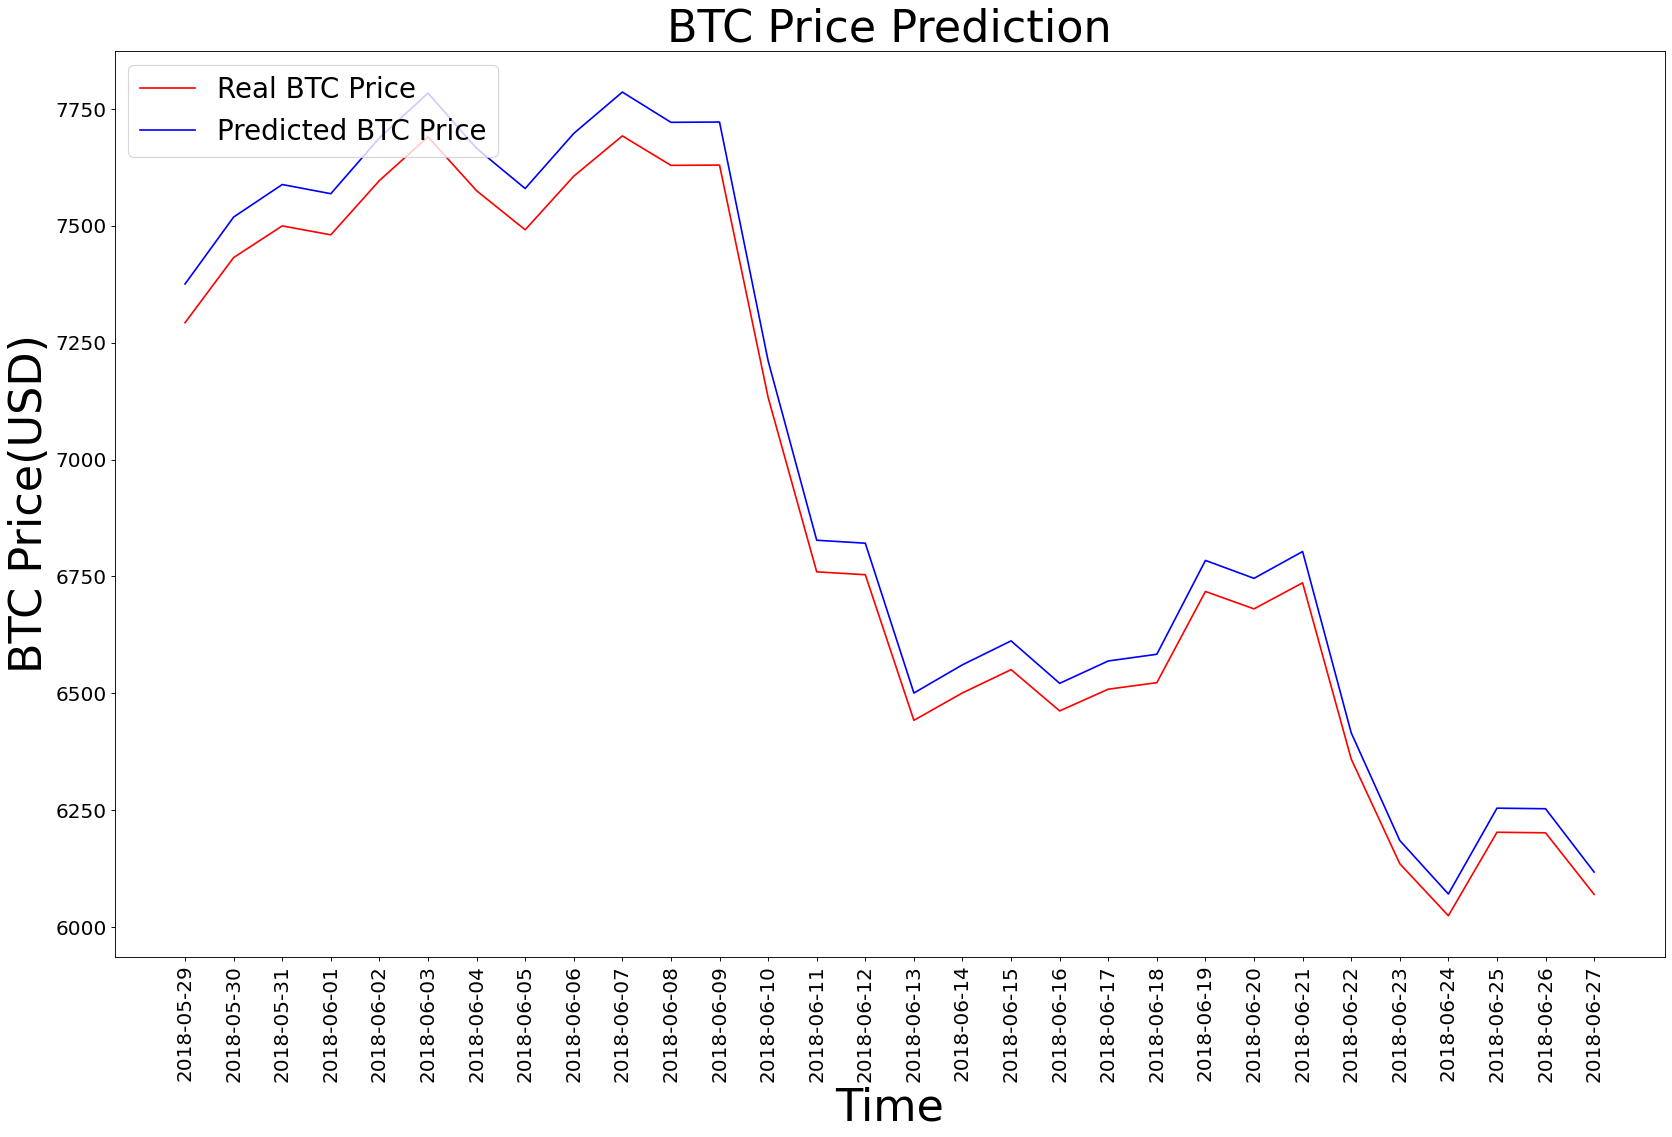

In [15]:
### visualize the results 
print("Visualize the results:") 
print('')

### plot the actual and predicted prices 
plt.figure(figsize =(25, 15), dpi =80, facecolor ='w', edgecolor ='k')
ax = plt.gca() 
plt.plot(test_set, color = 'red', label = "Real BTC Price") 
plt.plot(predicted_BTC_price, color = 'blue', label = "Predicted BTC Price") 
plt.title("BTC Price Prediction", fontsize = 40)

### reindex the 'df_test' dataframe 
df_test = df_test.reset_index() 
x = df_test.index

### set labels
labels = df_test['date']

### set xticks 
plt.xticks(x, labels, rotation = 'vertical')

### set fontsize for 'x' and 'y' ticks 
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
    
### set plot labels 
plt.xlabel('Time', fontsize = 40)
plt.ylabel('BTC Price(USD)', fontsize = 40)

### set plot legend
plt.legend(loc = 2, prop = {'size' : 25})  

### show the plot 
plt.show()    

In [16]:
### end of notebook 
print("This is the end") 

This is the end


In [17]:
!pip freeze

absl-py==1.2.0
aiohttp==3.8.1
aiosignal==1.2.0
alabaster==0.7.12
albumentations==1.2.1
alembic==1.8.1
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.1.0
audioread==2.1.9
autograd==1.4
Babel==2.10.3
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.8
bokeh==2.3.3
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==2.0.8
certifi==2022.6.15
cffi==1.15.1
cftime==1.6.1
chardet==3.0.4
charset-normalizer==2.1.0
click==7.1.2
clikit==0.6.2
cloudpickle==1.3.0
cmake==3.22.6
cmdstanpy==1.0.4
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.2.1
cycler==0.11.0
cymem==2.0.6
Cython==0.29.32
daft==0.0.4
dask==2.12.0
databricks-cli==0.17.0
datascience==0.17.5
deb

In [18]:
import pickle

In [20]:
with open('model_pkl', 'wb') as files:
    pickle.dump(regr, files)

INFO:tensorflow:Assets written to: ram://7d2d0cc5-d36b-497e-8756-075a526f5f7d/assets


INFO:tensorflow:Assets written to: ram://7d2d0cc5-d36b-497e-8756-075a526f5f7d/assets
